In [1]:
import Pkg
Pkg.activate(@__DIR__)

  Activating new project at `~/NERSC/slurm-preemption-experiments/experiments`


In [35]:
using Revise, JSON, Dates, Plots, StatsBase, TimeZones, Chain, CodecXz

In [10]:
jobs_db = open("jobs_db.json.xz") do stream
    read(XzDecompressorStream(stream), String) |> JSON.parse
end

Dict{String, Any} with 338501 entries:
  "21044587" => Dict{String, Any}("startTime"=>1706615737, "jobDerivedExitCode"…
  "21221454" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706852…
  "21169602" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706771…
  "21047233" => Dict{String, Any}("startTime"=>1706578697, "jobDerivedExitCode"…
  "20934399" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706471…
  "20957355" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706505…
  "21163296" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706763…
  "20998710" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706538…
  "20928464" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706429…
  "20929672" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706457…
  "21048255" => Dict{String, Any}("startTime"=>1706582301, "jobDerivedExitCode"…
  "21061706" => Dict{String, Any}("startTime"=>1706613630, "jobDerived

In [54]:
patient_apps = filter(((k, v),)->v["name"] == "patient_app", jobs_db)
preemptible_apps = filter(((k, v),)->contains(join(v["argv"], " "), "preemptible.sh"), patient_apps)
preempting_apps = filter(((k, v),)->contains(join(v["argv"], " "), "preempting"), patient_apps)

# sanity check
a = Set(map(x->parse(Int64, x), collect(keys(patient_apps))))
b = Set(map(x->parse(Int64, x), collect(keys(preemptible_apps))))
c = Set(map(x->parse(Int64, x), collect(keys(preempting_apps))))
a == union(b, c)

true

In [55]:
epoch_utc(dt::DateTime) = @chain dt begin
    ZonedDateTime(_, tz"America/Los_Angeles")
    astimezone(_, tz"UTC")
    DateTime(_)
    datetime2unix(_)
    floor(Int, _)
end

epoch_utc (generic function with 1 method)

In [56]:
epoch_utc(now())

1713421046

In [57]:
datetime_utc(ep::Int64) = @chain ep begin
    unix2datetime(_)
    ZonedDateTime(_, tz"UTC")
    astimezone(_, tz"America/Los_Angeles")
    DateTime(_)
end

datetime_utc (generic function with 1 method)

In [69]:
patient_apps

Dict{String, Any} with 4904 entries:
  "21153354" => Dict{String, Any}("jobDerivedExitCode"=>256, "startTime"=>17067…
  "21153745" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706743…
  "21211131" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706829…
  "21207917" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706821…
  "21153098" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706741…
  "21150664" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706738…
  "21208277" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706822…
  "21232266" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706903…
  "21211574" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706831…
  "21153458" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706742…
  "21155536" => Dict{String, Any}("startTime"=>1706749949, "jobDerivedExitCode"…
  "21201168" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>

In [70]:
unix2datetime(jobs_db["21153354"]["submitTime"])

2024-01-31T22:51:16

In [71]:
datetime_utc(jobs_db["21153354"]["submitTime"])

2024-01-31T14:51:16

In [73]:
datetime_utc(jobs_db["21153354"]["submitTime"]) < Date("2024-01-29")

false

In [85]:
dates = Set([Date(datetime_utc(patient_apps[k]["submitTime"])) for k in keys(patient_apps)])

Set{Date} with 4 elements:
  Date("2024-02-01")
  Date("2024-01-30")
  Date("2024-02-02")
  Date("2024-01-31")

In [94]:
patient_apps_1 = filter(((k, v),)->Date("2024-01-30")<=datetime_utc(v["submitTime"])<Date("2024-01-31"), patient_apps)
patient_apps_2 = filter(((k, v),)->Date("2024-01-31")<=datetime_utc(v["submitTime"])<Date("2024-02-01"), patient_apps)
patient_apps_3 = filter(((k, v),)->Date("2024-02-01")<=datetime_utc(v["submitTime"])<Date("2024-02-02"), patient_apps)
patient_apps_4 = filter(((k, v),)->Date("2024-02-02")<=datetime_utc(v["submitTime"])<Date("2024-02-03"), patient_apps)

preemptible_apps_1 = filter(((k, v),)->Date("2024-01-30")<=datetime_utc(v["submitTime"])<Date("2024-01-31"), preemptible_apps)
preemptible_apps_2 = filter(((k, v),)->Date("2024-01-31")<=datetime_utc(v["submitTime"])<Date("2024-02-01"), preemptible_apps)
preemptible_apps_3 = filter(((k, v),)->Date("2024-02-01")<=datetime_utc(v["submitTime"])<Date("2024-02-02"), preemptible_apps)
preemptible_apps_4 = filter(((k, v),)->Date("2024-02-02")<=datetime_utc(v["submitTime"])<Date("2024-02-03"), preemptible_apps)

preempting_apps_1 = filter(((k, v),)->Date("2024-01-30")<=datetime_utc(v["submitTime"])<Date("2024-01-31"), preempting_apps)
preempting_apps_2 = filter(((k, v),)->Date("2024-01-31")<=datetime_utc(v["submitTime"])<Date("2024-02-01"), preempting_apps)
preempting_apps_3 = filter(((k, v),)->Date("2024-02-01")<=datetime_utc(v["submitTime"])<Date("2024-02-02"), preempting_apps)
preempting_apps_4 = filter(((k, v),)->Date("2024-02-02")<=datetime_utc(v["submitTime"])<Date("2024-02-03"), preempting_apps)

Dict{String, Any} with 207 entries:
  "21247775" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706918…
  "21240979" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706911…
  "21245615" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706913…
  "21235267" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706906…
  "21240278" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706911…
  "21237771" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706908…
  "21247772" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706917…
  "21237777" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706908…
  "21237763" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706908…
  "21237773" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706908…
  "21247781" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1706919…
  "21250855" => Dict{String, Any}("jobDerivedExitCode"=>0, "startTime"=>1

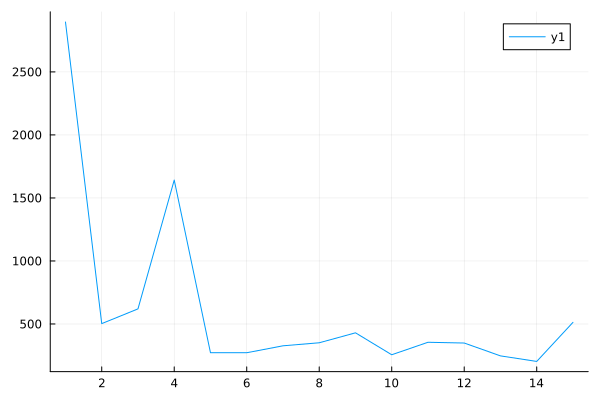

In [107]:
data = sort(collect(preempting_apps_1), by = x->last(x)["submitTime"])
y = [v["startTime"]-v["submitTime"] for (k, v) in data]
plot(y)

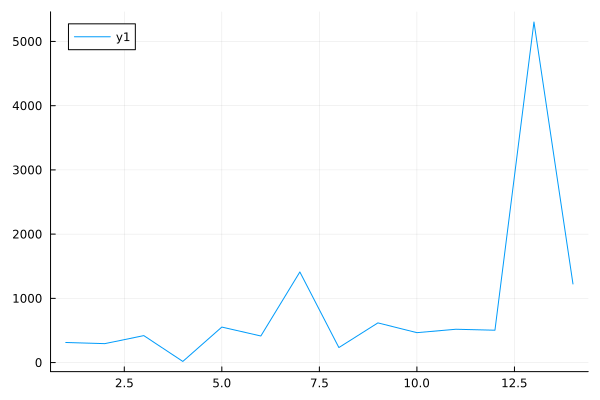

In [108]:
data = sort(collect(preempting_apps_2), by = x->last(x)["submitTime"])
y = [v["startTime"]-v["submitTime"] for (k, v) in data]
plot(y)

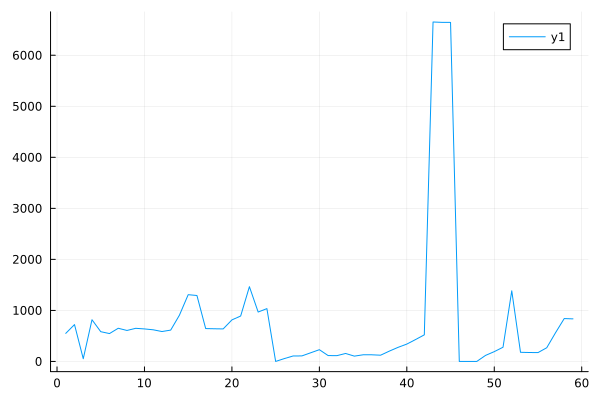

In [109]:
data = sort(collect(preempting_apps_3), by = x->last(x)["submitTime"])
y = [v["startTime"]-v["submitTime"] for (k, v) in data]
plot(y)

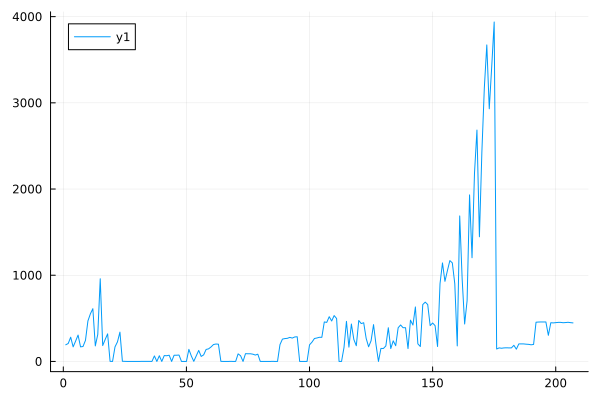

In [110]:
data = sort(collect(preempting_apps_4), by = x->last(x)["submitTime"])
y = [v["startTime"]-v["submitTime"] for (k, v) in data]
plot(y)

In [64]:
JSON.print(jobs_db["20928794"], 4)

{
    "jobDerivedExitCode": 0,
    "startTime": 1706444036,
    "submitTime": 1706432342,
    "endTime": 1706453453,
    "gresRequest": "cpu=64,mem=488002M,node=1,billing=64",
    "tresRequest": "1=256,2=488002,3=18446744073709551614,4=1,5=256",
    "stdoutPath": "/pscratch/sd/a/agordeev/slurm/%x-%j",
    "priority": 67683,
    "jobId": 20928794,
    "packJobId": 0,
    "batchHost": "nid006837",
    "jobExitCode": 0,
    "licenses": "scratch:1,u1:1",
    "allocNodes": 1,
    "name": "newsimple",
    "jobAccount": "m2730",
    "allocCpus": 256,
    "stderrPath": "/pscratch/sd/a/agordeev/slurm/%x-%j",
    "resizing": 0,
    "uid": 92690,
    "argv": [
        "/global/u1/a/agordeev/music-eventgen/nersc/examples/newsimple"
    ],
    "reboot": 0,
    "arrayTaskId": 4294967294,
    "timeLimit": 240,
    "cluster": "perlmutter",
    "restartCnt": 0,
    "nodes": "nid006837",
    "stdinPath": "/dev/null",
    "arrayJobId": 0,
    "features": "cpu",
    "qos": "regular_1",
    "workingDirecto